In [ ]:
%pip install ollama

In [ ]:
%pip install matplotlib

In [3]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!ollama list

NAME           ID              SIZE      MODIFIED     
qwen3:32b      030ee887880f    20 GB     27 hours ago    
gpt-oss:20b    aa4295ac10c3    13 GB     27 hours ago    
gemma3:12b     f4031aab637d    8.1 GB    27 hours ago    
llama3.2:1b    baf6a787fdff    1.3 GB    27 hours ago    
mistral:7b     6577803aa9a0    4.4 GB    27 hours ago    
r1-1776:70b    140ea940f21d    42 GB     6 days ago      
gemma3:270m    e7d36fb2c3b3    291 MB    6 days ago      


In [ ]:
!ollama pull mistral:7b

In [ ]:
!ollama pull llama3.2:1b

In [ ]:
!ollama pull gemma3:12b

In [ ]:
!ollama pull gpt-oss:20b

In [1]:
def build_prompt(query_book, query_summary, examples, n_shots=0):
    # Base context
    context = """You classify books based on whether they are STEM."""
    # Add few-shot examples
    shots = ""
    for i in range(min(n_shots, len(examples))):
        ex = examples[i]
        shots += f"""
Here is an example problem and answer::
Question: Is this book "{ex['id']}" STEM? Here is the book summary: "{ex['summary']}" 
Answer: {ex['answer']}
"""
    
    # Add the actual query
    query = f"""
Only classify this book in your response: {query_book}:
Is this book "{query_book}" STEM? Here is the book summary: "{query_summary}"
Respond only with true or false for whether the book is STEM.
"""
    
    return context + shots + query

In [2]:
import ollama

def run_ollama(prompt, model):
    response = ollama.chat(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response["message"]["content"].strip()

In [ ]:
#The standardized version
import pandas as pd
import csv
import os

queries_csv = pd.read_csv("books_english.csv")
examples_csv = pd.read_csv("standard_books.csv")
def age_to_group(age):
    if 12 <= age < 14:
        return "12-13"
    elif 14 <= age < 16:
        return "14-15"
    elif 16 <= age < 18:
        return "16-17"
    else:
        return "18+"
# Build few-shot example pool
few_shot_examples = []
for _, row in examples_csv.iterrows():
    few_shot_examples.append({
        "title": row["title"],
        "description": row["description"],
        "vector": row["emotion_vector"],
        "answer": age_to_group(row["age"])
    })
fixed_examples_by_shot = {
    1: [few_shot_examples[2]],
    3: few_shot_examples[1:4],
    5: few_shot_examples[0:5]
}
models = ['llama3.2:1b', 'mistral:7b', 'gemma3:12b', 'gpt-oss:20b']
shot_settings = [0, 1, 3, 5]
query_rows = queries_csv.sample(10)
# Prepare CSV for incremental saving
results_file = "4ModelsStandardized.csv"
write_header = not os.path.exists(results_file)
if write_header:
    with open(results_file, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=[
            "model", "shots", "book", "answer", "ground_truth_age"
        ])
        writer.writeheader()
results = []
for _, query_row in query_rows.iterrows():
    query_book = query_row["title"]
    query_description = query_row["description"]
    query_vector = query_row["emotion_vector"]
    query_age = query_row["age"]
    groundTruthAgeGroup = age_to_group(query_age)
    print("Processing book:", query_book, "age:", query_age)
    for model in models:
        for n_shots in shot_settings:
            examples = fixed_examples_by_shot.get(n_shots, [])
            example_titles = [ex["title"] for ex in examples]
            for i in range(5):  # multiple trials per config
                prompt = build_prompt(query_book, query_description, query_vector, examples, n_shots)
                try:
                    answer = run_ollama(prompt, model=model)
                    clean_answer = answer.strip().splitlines()[-1]
                except Exception as e:
                    print(f":warning: Error with model={model}, shots={n_shots}, trial={i}, book={query_book}: {e}")
                    continue  # skip this one and keep going
                row = {
                    "model": model,
                    "shots": n_shots,
                    "book": query_book,
                    "answer": clean_answer,
                    "ground_truth_age": groundTruthAgeGroup
                    #"example_books":"; ".join(example_titles)
                }
                results.append(row)
                with open(results_file, "a", newline="") as f:
                    writer = csv.DictWriter(f, fieldnames=row.keys())
                    writer.writerow(row)
# Optional: still gather into a DataFrame at the end
df = pd.DataFrame(results)
df.to_csv("4ModelsStandardized.csv", index=False)

Processing book: Ghost Fox age: 17.0


NameError: name 'build_prompt' is not defined

In [ ]:
#standardized
import random
import pandas as pd

queries_csv = pd.read_csv("Code/combined_emotions.csv")
examples_csv = pd.read_csv("Code/stem_standard.csv")

few_shot_examples = []
for _, row in examples_csv.iterrows():
    few_shot_examples.append({
        "id": row["id"],
        "summary": row["summary"],
        "answer": row["is_stem_ground_truth"]
    })
fixed_examples_by_shot = {
    1: [few_shot_examples[2]],
    3: few_shot_examples[1:4],
    5: few_shot_examples[0:5]
}
models = ['llama3.2:1b', 'mistral:7b', 'gemma3:12b'] #'gpt-oss:20b'
shot_settings = [0, 1, 5, 10]
query_rows = queries_csv.sample(15)
results = []
for _, query_row in query_rows.iterrows():
    query_book = query_row["id"]
    query_summary = query_row["summary"]
    query_truth = query_row["is_stem_ground_truth"]
    print(query_book)
    for model in models:
        for n_shots in shot_settings:
            examples = fixed_examples_by_shot.get(n_shots, [])
            for i in range(5): #arbitrary number to see any variance in LLM response with the same prompt
                prompt = build_prompt(query_book, query_summary, examples, n_shots)
                answer = run_ollama(prompt, model=model)
                results.append({
                    "model": model,
                    "shots": n_shots,
                    "book": query_book,
                    "answer": answer,
                    "ground_truth_stem": query_truth
                })
df = pd.DataFrame(results)
df.to_csv("4ModelsSTEMstandard.csv", index=False)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [9]:
#The randomized version
import random
import pandas as pd

examples_csv = pd.read_csv("Code/combined_emotions.csv")

few_shot_examples = []
for _, row in examples_csv.iterrows():
    few_shot_examples.append({
        "id": row["id"],
        "summary": row["summary"],
        "answer": row["is_stem_ground_truth"]
    })
models = ['llama3.2:1b', 'mistral:7b', 'gemma3:12b', 'gpt-oss:20b'] #'gpt-oss:20b'
shot_settings = [0, 1, 5, 10]
query_rows = examples_csv.sample(15)
results = []
for _, query_row in query_rows.iterrows():
    query_book = query_row["id"]
    query_summary = query_row["summary"]
    query_truth = query_row["is_stem_ground_truth"]
    print(query_book)
    for model in models:
        for n_shots in shot_settings:
            examples = random.sample(few_shot_examples, min(n_shots, len(few_shot_examples)))
            for i in range(5): #arbitrary number to see any variance in LLM response with the same prompt
                prompt = build_prompt(query_book, query_summary, examples, n_shots)
                answer = run_ollama(prompt, model=model)
                results.append({
                    "model": model,
                    "shots": n_shots,
                    "book": query_book,
                    "answer": answer,
                    "ground_truth_stem": query_truth
                })
df = pd.DataFrame(results)
df.to_csv("4ModelsSTEMrandom1.csv", index=False)

Harry Potter and the Goblet of Fire (Harry Potter, #4)
The Amazing World of Video Game Development
Transported: 50 Vehicles That Changed the World
Number the Stars
Einstein: The Fantastic Journey of a Mouse Through Space and Time
9780321795465
The Scarlet Letter
1576854000
978-0-536-21012-8
Tuesdays with Morrie: An Old Man, a Young Man and Life's Greatest Lesson
0-02-823102-3
From Here to There: Inventions That Changed the Way the World Moves
The Message (Animorphs, #4)
0-86709-447-8
Mission to the Bottom of the Sea


In [10]:
import pandas as pd
import re

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv("4ModelsSTEMrandom1.csv")

# ---------------------------
# Extract boolean answer (True/False)
# ---------------------------
def extract_bool(text):
    if pd.isna(text):
        return None
    text = str(text).lower()
    match = re.search(r"\b(true|false)\b", text)
    if match:
        return True if match.group(1) == "true" else False
    
    yes_match = re.search(r"\b(yes|y|yep|yeah)\b", text)
    if yes_match:
        return True

    no_match = re.search(r"\b(no|n|nope)\b", text)
    if no_match:
        return False
    
    return None

df["answer_clean"] = df["answer"].apply(extract_bool)

# ---------------------------
# Quick check preview
# ---------------------------
print(df[["answer", "answer_clean", "ground_truth_stem"]].head(15))

# ---------------------------
# Save updated CSV
# ---------------------------
df.to_csv("4modelsSTEMrandom1.csv", index=False)

print("\nSaved cleaned file")

    answer  answer_clean  ground_truth_stem
0    False         False              False
1    False         False              False
2   False.         False              False
3    False         False              False
4   False.         False              False
5    False         False              False
6    False         False              False
7    False         False              False
8    False         False              False
9    False         False              False
10   False         False              False
11    True          True              False
12  False.         False              False
13   False         False              False
14   False         False              False

Saved cleaned file


In [11]:
import random
import pandas as pd

df = pd.read_csv("4modelsSTEMrandom1.csv")
bad_rows = df[df["answer_clean"].isna()].copy()

# Add a column for the original CSV line number (index + 2, since header is line 1)
bad_rows["csv_line_number"] = bad_rows.index + 2

# Print them out
print(bad_rows[["csv_line_number", "answer", "ground_truth_stem"]].to_string(index=False))

Empty DataFrame
Columns: [csv_line_number, answer, ground_truth_stem]
Index: []


Accuracy by shots:
Shots = 0.0: 81.33%
Shots = 1.0: 81.67%
Shots = 5.0: 83.00%
Shots = 10.0: 81.67%


/tmp/ipykernel_572839/2459822764.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("shots")


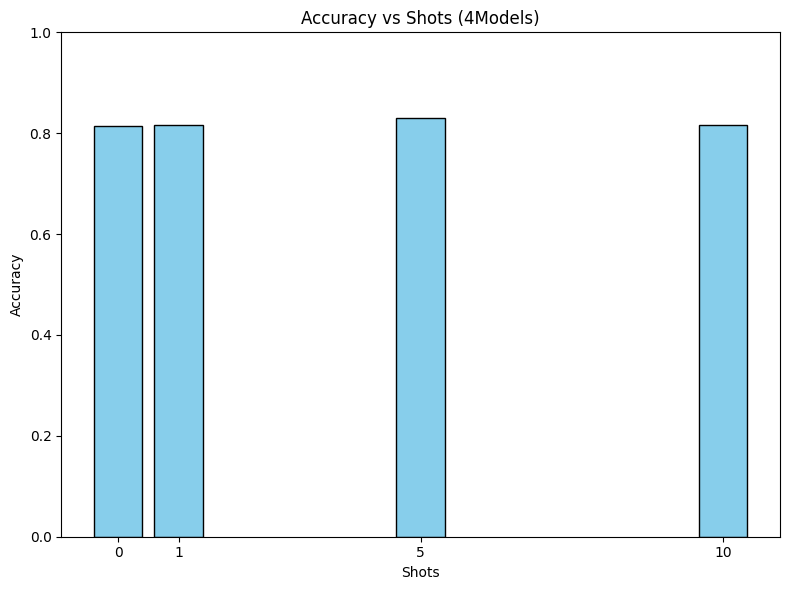

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your file
df = pd.read_csv("4modelsSTEMrandom1.csv")

# Normalize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Compute accuracy per shot
accuracy = (
    df.groupby("shots")
    .apply(lambda g: np.mean(g["answer_clean"] == g["ground_truth_stem"]))
    .reset_index(name="accuracy")
)

# Print accuracy values
print("Accuracy by shots:")
for _, row in accuracy.iterrows():
    print(f"Shots = {row['shots']}: {row['accuracy']:.2%}")

# Plot bar chart
plt.figure(figsize=(8,6))
plt.bar(accuracy["shots"], accuracy["accuracy"], color="skyblue", edgecolor="black")

plt.title("Accuracy vs Shots (4Models)")
plt.xlabel("Shots")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # accuracy goes from 0 to 1
plt.xticks(accuracy["shots"])
plt.tight_layout()
#plt.savefig("accuracy_vs_shots_gemma3.pdf", bbox_inches="tight")
plt.show()


Accuracy by model and shots:

Model: gemma3:12b
  Shots = 0: 93.33%
  Shots = 1: 93.33%
  Shots = 5: 93.33%
  Shots = 10: 93.33%

Model: gpt-oss:20b
  Shots = 0: 93.33%
  Shots = 1: 98.67%
  Shots = 5: 96.00%
  Shots = 10: 98.67%

Model: llama3.2:1b
  Shots = 0: 48.00%
  Shots = 1: 54.67%
  Shots = 5: 49.33%
  Shots = 10: 58.67%

Model: mistral:7b
  Shots = 0: 90.67%
  Shots = 1: 80.00%
  Shots = 5: 93.33%
  Shots = 10: 76.00%


/tmp/ipykernel_572839/2852476864.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(["model", "shots"])


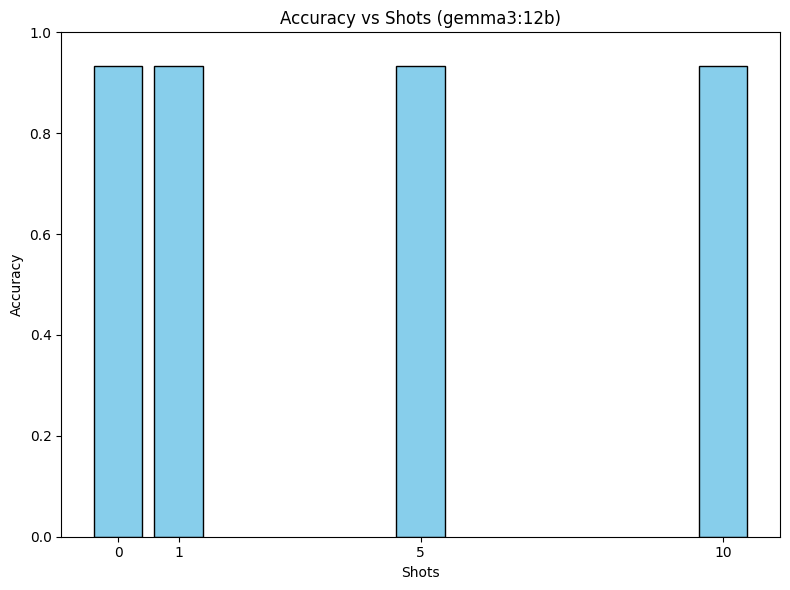

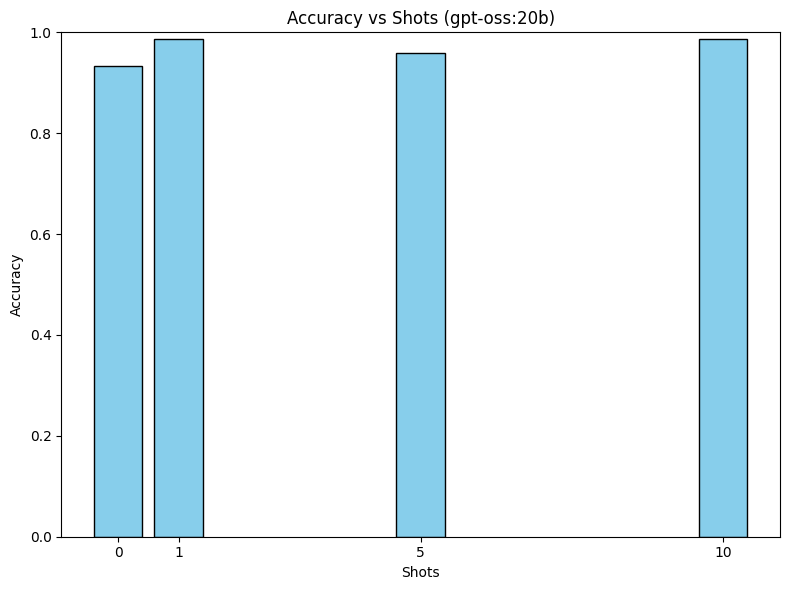

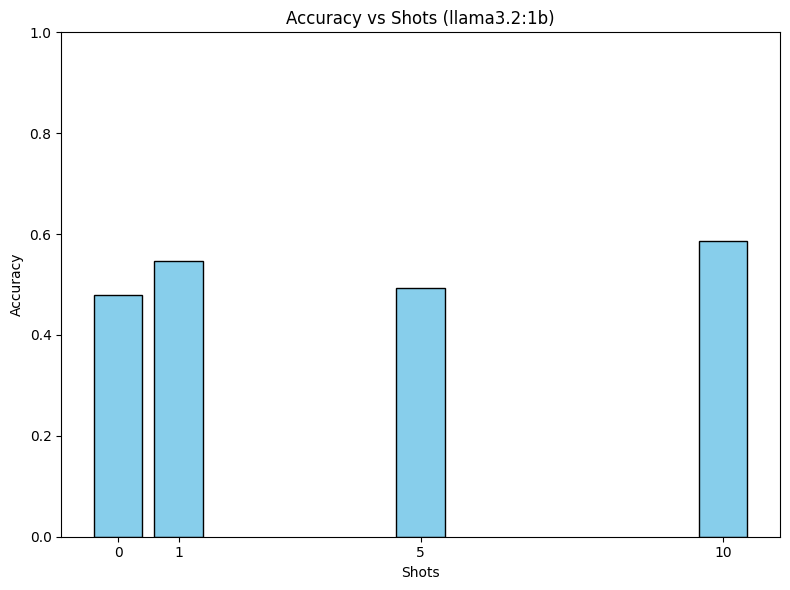

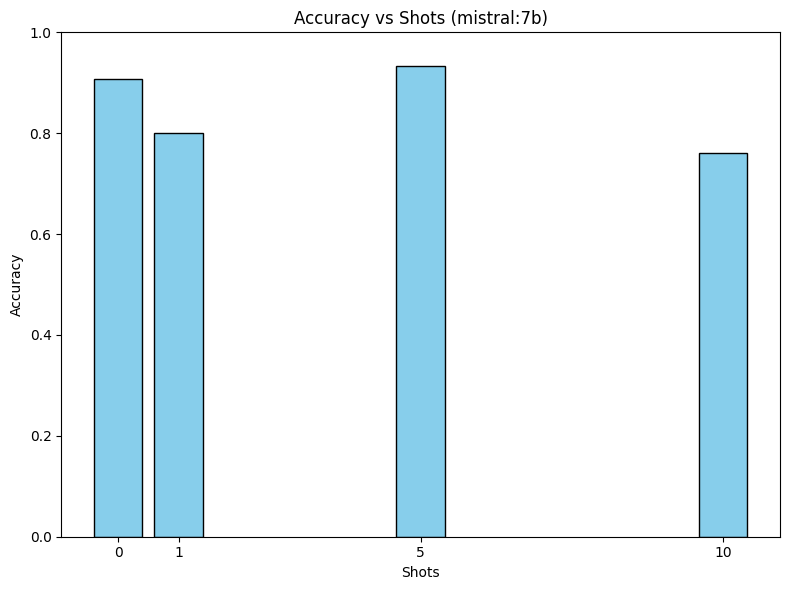

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your file (replace with your actual filename)
df = pd.read_csv("4modelsSTEMrandom1.csv")

# Normalize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Compute accuracy per model per shot
accuracy = (
    df.groupby(["model", "shots"])
    .apply(lambda g: np.mean(g["answer_clean"] == g["ground_truth_stem"]))
    .reset_index(name="accuracy")
)

# Print accuracy values
print("Accuracy by model and shots:")
for model in accuracy["model"].unique():
    print(f"\nModel: {model}")
    model_acc = accuracy[accuracy["model"] == model]
    for _, row in model_acc.iterrows():
        print(f"  Shots = {row['shots']}: {row['accuracy']:.2%}")

# Plot separate bar chart for each model
models = accuracy["model"].unique()
for model in models:
    subset = accuracy[accuracy["model"] == model]

    plt.figure(figsize=(8,6))
    plt.bar(subset["shots"], subset["accuracy"], color="skyblue", edgecolor="black")

    plt.title(f"Accuracy vs Shots ({model})")
    plt.xlabel("Shots")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(subset["shots"])
    plt.tight_layout()
    plt.show()
